### Import libraries and add useful functions.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
w, h = 1280, 720
img_size = (w, h) # image size
nw, nh = 9, 6

In [3]:
def read_img(fname):
    # return cv2.imread(fname)
    return cv2.cvtColor(
        cv2.imread(fname),
        cv2.COLOR_BGR2RGB
    )

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [4]:
def find_corners(img):
    return cv2.findChessboardCorners(
        grayscale(img), (nw, nh), None
    )

### Draw chessboard corners.

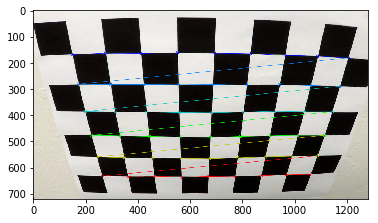

In [5]:
cal2 = read_img('camera_cal/calibration2.jpg')
success, corners = find_corners(cal2)
if success:
    cal2_copy = cal2.copy() # drawChessboardCorners modifies its parameter
    cv2.drawChessboardCorners(cal2_copy, (nw, nh), corners, True)
    plt.imshow(cal2_copy)

### Read corners from calibration images.

In [6]:
# Arrays to store object points and image points from all the images
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

objp = np.zeros((nw * nh, 3), np.float32)
objp[:,:2] = np.mgrid[0:nw, 0:nh].T.reshape(-1, 2) # x, y coordinate

for i in range(1, 21):
    img = read_img('camera_cal/calibration{}.jpg'.format(i))
    success, corners = find_corners(img)

    if success == True:
        imgpoints.append(corners)
        objpoints.append(objp)

### Calibrate camera.

In [7]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(
    objpoints, imgpoints, img_size, None, None
)

### Create undestort, and add visualization.

Text(0.5,1,'Undistorted Image')

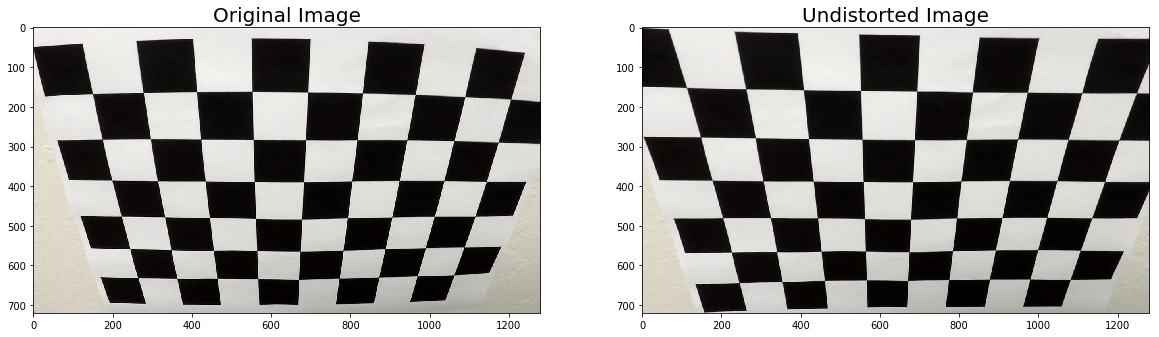

In [8]:
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

cal2_und = undistort(cal2)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(cal2)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(cal2_und)
ax2.set_title('Undistorted Image', fontsize=20)

### Warp image *(view from top)*.

In [9]:
# define source and destination points for transform
trap = np.float32([
    (570 , 480),  # top left
    (780 , 480),  # top right
    (250 ,   h),    # bottom left
    (1130,   h)    # bottom right
])
offset = 300

dst = np.float32([
    (offset  , offset),
    (w-offset, offset),
    (offset  , h),
    (w-offset, h)
])

In [10]:
def warp(img):
    M = cv2.getPerspectiveTransform(trap, dst)
    M_inv = cv2.getPerspectiveTransform(dst, trap)
    return cv2.warpPerspective(img, M, img_size), M_inv

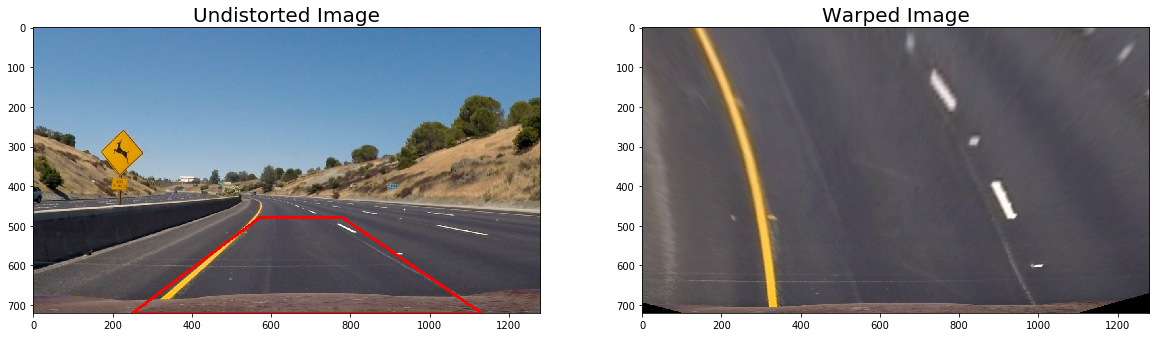

In [11]:
test_img = read_img('test_images/test2.jpg')

warped, M_inv = warp(test_img)

def visualize_warped():
    drawn_img = test_img.copy()
    # convert to int32
    pts = np.array([trap[2], trap[3], trap[1], trap[0]], np.int32)
    pts = pts.reshape((-1,1,2))
    cv2.polylines(drawn_img, [pts], True,(255,0,0), thickness=6)

    # Visualization
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(drawn_img, interpolation='none')
    ax1.set_title('Undistorted Image', fontsize=20)
    ax2.imshow(warped)
    ax2.set_title('Warped Image', fontsize=20)
    

visualize_warped()

# Gradient thresholds.

In [12]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(gray, orient='x', thresh_min=20, thresh_max=255):
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

In [13]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(gray, sobel_kernel=3, mag_thresh=(30, 100)):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

In [14]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(gray, sobel_kernel=3, thresh=(0.7, 1.3)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [15]:
def combine_thresholds(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gradx = abs_sobel_thresh(gray, 'x')
    grady = abs_sobel_thresh(gray, 'x')
    mag_binary = mag_thresh(gray)
    dir_binary = dir_threshold(gray)
    combined_grads = np.zeros_like(gradx)
    combined_grads[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined_grads

### Visualize all gradient thresholds.

Text(0.5,1,'Combined Thresholds.')

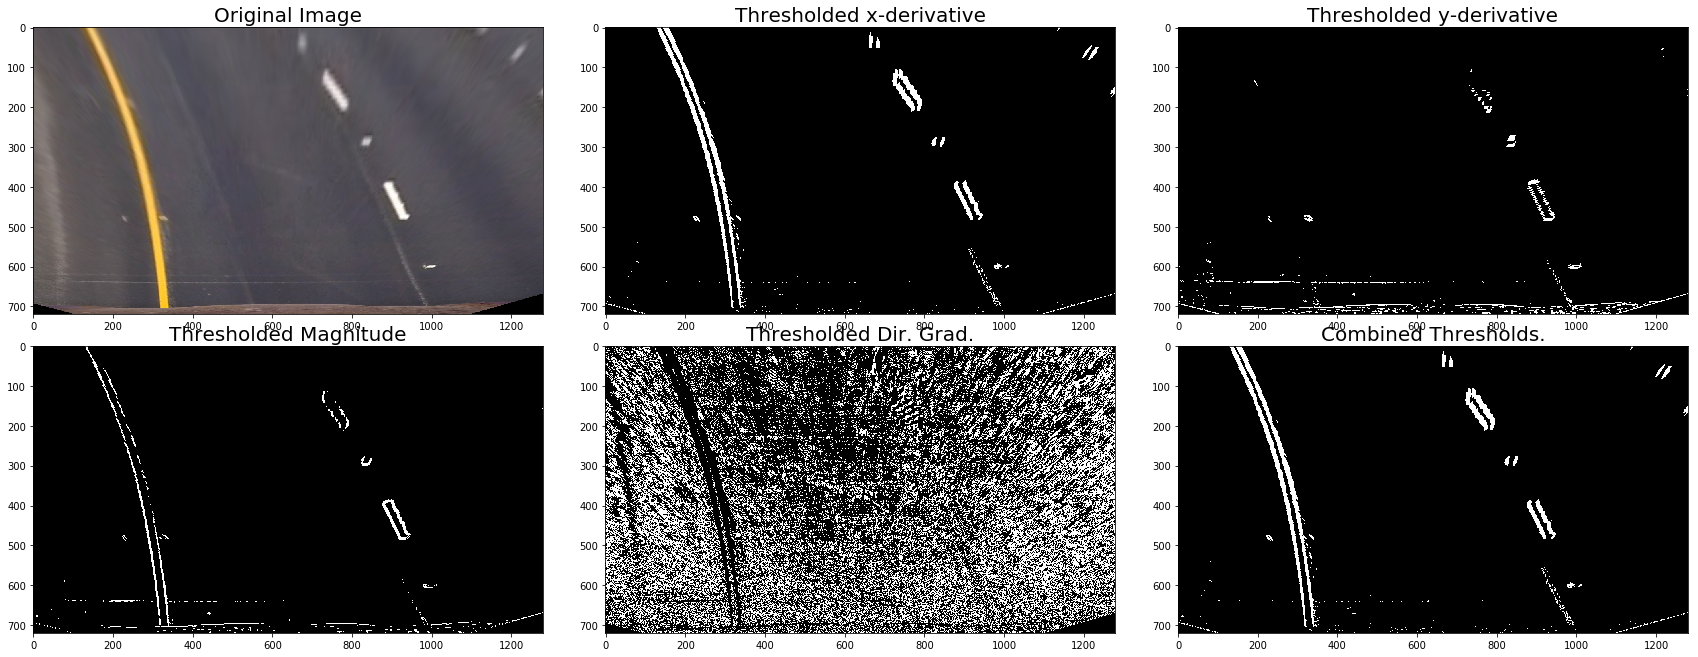

In [16]:
warped_gray = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)

gradx = abs_sobel_thresh(warped_gray, 'x')
grady = abs_sobel_thresh(warped_gray, 'y')
mag_binary = mag_thresh(warped_gray)
dir_binary = dir_threshold(warped_gray)

combined_thresholds = combine_thresholds(warped)

f, axs = plt.subplots(2, 3, figsize=(24, 9))
f.tight_layout()
axs[0][0].imshow(warped)
axs[0][0].set_title('Original Image', fontsize=20)
axs[0][1].imshow(gradx, cmap='gray')
axs[0][1].set_title('Thresholded x-derivative', fontsize=20)
axs[0][2].imshow(grady, cmap='gray')
axs[0][2].set_title('Thresholded y-derivative', fontsize=20)
axs[1][0].imshow(mag_binary, cmap='gray')
axs[1][0].set_title('Thresholded Magnitude', fontsize=20)
axs[1][1].imshow(dir_binary, cmap='gray')
axs[1][1].set_title('Thresholded Dir. Grad.', fontsize=20)
axs[1][2].imshow(combined_thresholds, cmap='gray')
axs[1][2].set_title('Combined Thresholds.', fontsize=20)

# Color spaces.

In [17]:
def print_channels(imgs, labels):
    f, axs = plt.subplots(1, 3, figsize=(20,10))
    for i in range(3):
        axs[i].set_title(labels[i], fontsize=20)
        axs[i].imshow(imgs[i], cmap='gray')

### RGB.

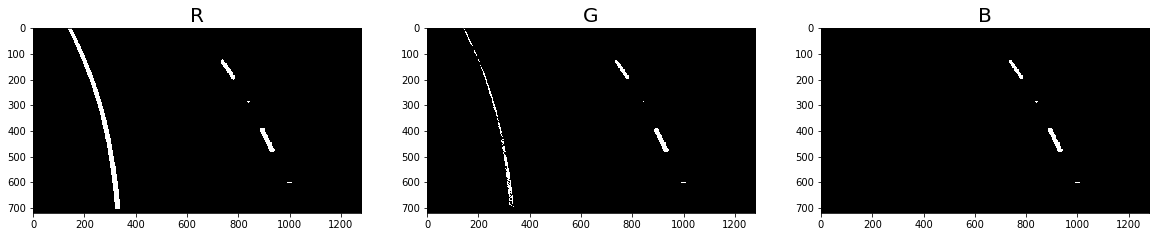

In [18]:
def rgb_channels(img):
    images = []
    for i in range(3):
        im = img[:,:,i]
        binary = np.zeros_like(im)
        binary[(im > 200) & (im <= 255)] = 1
        images.append(binary)
    return images

print_channels(rgb_channels(warped), ['R','G','B'])

### HLS.

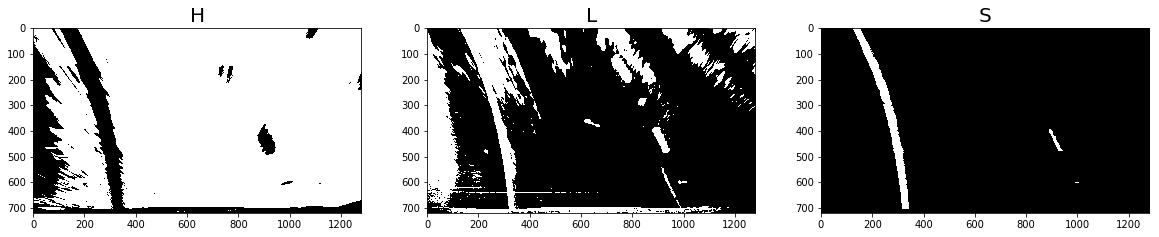

In [19]:
def hls_channels(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    images = []
    for i in range(3):
        im = hls[:,:,i]
        binary = np.zeros_like(im)
        binary[(im > 90) & (im <= 255)] = 1
        images.append(binary)
    return images

print_channels(hls_channels(warped), ['H','L','S'])

### HSV.

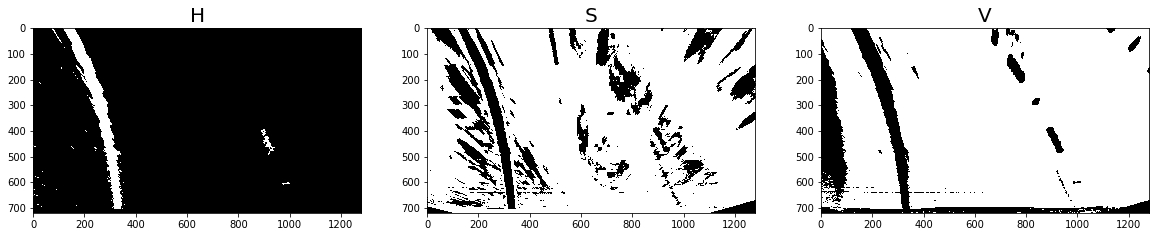

In [20]:
def hsv_channels(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    images = []
    for i in range(3):
        im = hsv[:,:,i]
        binary = np.zeros_like(im)
        binary[(im > 15) & (im <= 100)] = 1
        images.append(binary)
    return images

print_channels(hsv_channels(warped), ['H','S','V'])

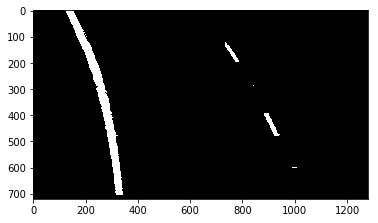

In [21]:
def combine_colors(img):
    [red, green, blue] = rgb_channels(img)
    sat = hls_channels(img)[2]
    hue = hsv_channels(img)[0]
    combined_colors = np.zeros_like(red)
    combined_colors[
        ((red == 1) & (green == 1)) | ((sat == 1) & (hue == 1))
    ] = 1
    return combined_colors
    
combined_colors = combine_colors(warped)
plt.imshow(combined_colors, cmap='gray')

## Combine color space and gradient threshold.

In [22]:
def combine_both(img):
    combined_thresholds = combine_thresholds(img)
    combined_colors = combine_colors(img)
    combined_both = np.zeros_like(combined_colors)
    combined_both[((combined_colors == 1) | (combined_thresholds == 1))] = 1
    return combined_both

### Visualize combination.

Text(0.5,1,'Combined Binary Image')

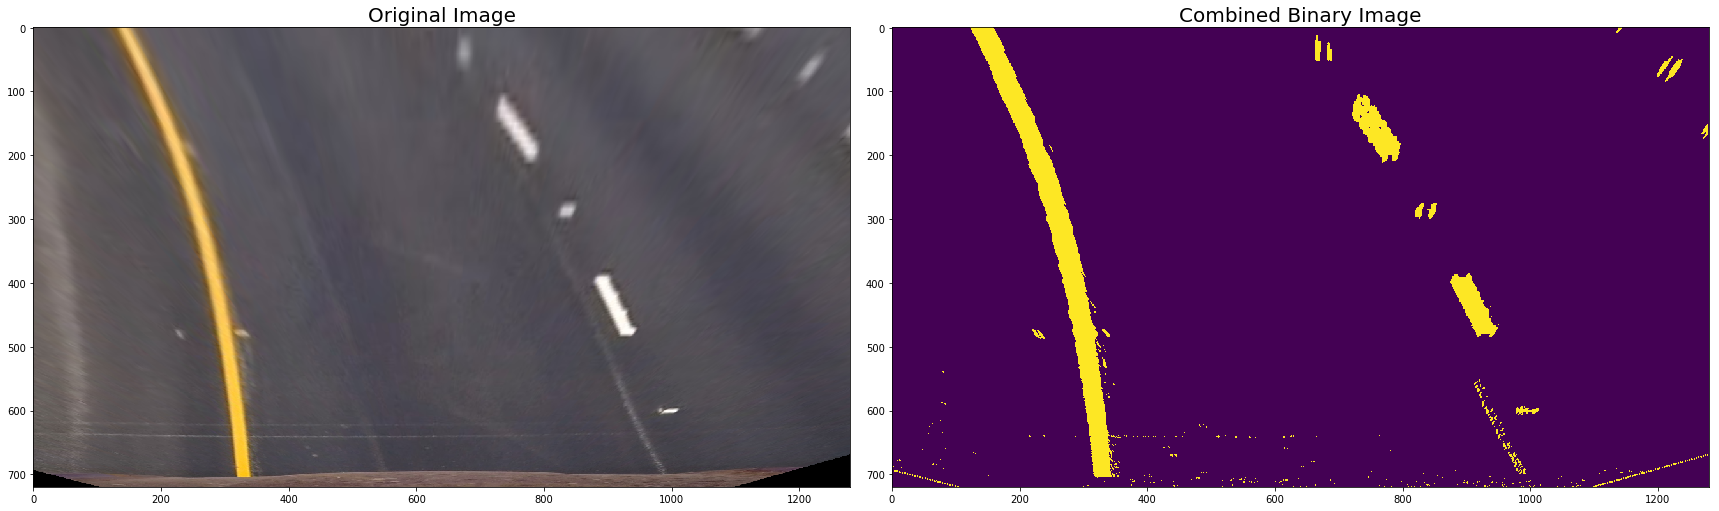

In [23]:
combined_both = combine_both(warped)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(warped)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(combined_both)
ax2.set_title('Combined Binary Image', fontsize=20)

### Clean up image.

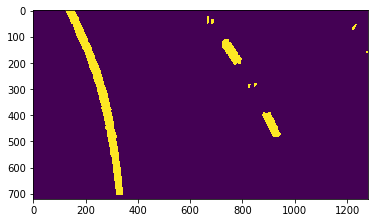

In [24]:
def remove_impurities(binary_img):
    BW = binary_img
    minThick = 8 # Define minimum thickness
    se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (minThick,minThick)) # define a disk element
    finalBW = 255*cv2.morphologyEx(BW.astype('uint8'), cv2.MORPH_OPEN, se) # "chop" half thickness from mask and dilate the eroded mask
    return finalBW
    
binary_lines = remove_impurities(combined_both)
plt.imshow(binary_lines)

## Finding lines.

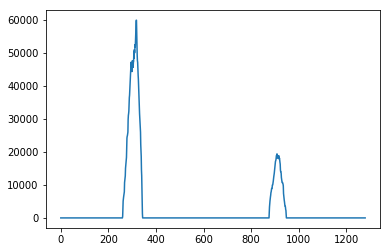

In [25]:
histogram = np.sum(binary_lines[binary_lines.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [26]:
# Method to determine radius of curvature and distance from lane center 
# based on binary image, polynomial fit, and L and R lane pixel indices
def calc_curvature(bin_img, left_fit, right_fit, left_lane_inds, right_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    xm_per_pix = 3.7/700 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    left_curve_rad, right_curve_rad, center_dist = (0, 0, 0)
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image

    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curve_rad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curve_rad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
    
    # Distance from center is image x midpoint - mean of left_fit and right_fit intercepts 
    if right_fit is not None and left_fit is not None:
        car_position = bin_img.shape[1]/2
        left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
        right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
        lane_center_position = (left_fit_x_int + right_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    
    return np.array(((left_curve_rad + right_curve_rad) / 2, center_dist))

In [27]:
def get_sliding_windows(binary_img, visualize = False):
    binary_warped = binary_img.copy()
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[h//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 12
    # Set height of windows
    window_height = np.int(h/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    curv = calc_curvature(
        binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds
    )
    
    if visualize:
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
    
    return (curv, left_fit, right_fit, left_fitx, right_fitx)

### Fit polynomial and view windows

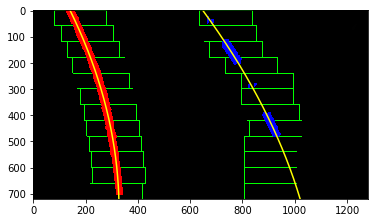

In [28]:
sliding_windows = get_sliding_windows(binary_lines, True)

In [29]:
curv = sliding_windows[0]
print('Curvature: ' + str(curv[0]) + 'm')
print('Distance from center: ' + str(curv[1]) + 'm')

Curvature: 529.43227234m
Distance from center: -0.1794794327m


### Find sliding windows based on previous found polynomials

In [30]:
def get_next_sliding_windows(binary_img, left_fit, right_fit, visualize = False):
    binary_warped = binary_img.copy()
    
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    curv = calc_curvature(
        binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds
    )
    
    if visualize:
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
    return (curv, left_fit, right_fit, left_fitx, right_fitx)

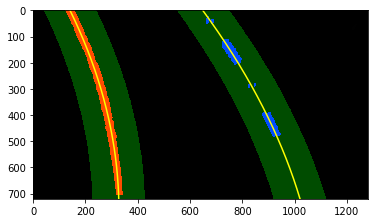

In [31]:
next_sliding_windows = get_next_sliding_windows(
    binary_lines, sliding_windows[1], sliding_windows[2], True
)

In [32]:
curv = sliding_windows[0]
print('Curvature: ' + str(curv[0]) + 'm')
print('Distance from center: ' + str(curv[1]) + 'm')

Curvature: 529.43227234m
Distance from center: -0.1794794327m


### Fill area from between the polynomials and add curvature info

In [37]:
def fill_area(initial_img, binary_img, left_fitx, right_fitx, curv):
    ploty = np.linspace(0, binary_img.shape[0]-1, binary_img.shape[0])
   
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, img_size) 
    # Combine the result with the original image
    result = cv2.addWeighted(initial_img, 1, newwarp, 0.3, 0)

    cv2.putText(
        result, "Radius of curvature: %.0fm." % curv[0], (20,40), cv2.FONT_HERSHEY_SIMPLEX, 1.1, (255,255,255), 3
    )
    cv2.putText(
        result, "Distance from center: %.2fm" % curv[1], (20,80), cv2.FONT_HERSHEY_SIMPLEX, 1.1, (255,255,255), 3
    )
    return result

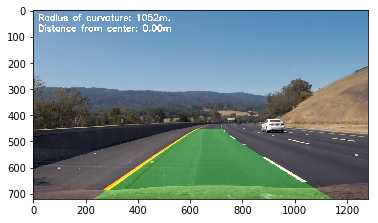

In [38]:
def process_img(img):
    global initial
    global left_fit
    global right_fit
    global left_fitx
    global right_fitx
    global curv

    p_und = undistort(img)
    p_warped, M_inv = warp(p_und)
    combined = combine_both(p_warped)
    bin_img = remove_impurities(combined)

    if initial == True:
        sliding_windows = get_sliding_windows(bin_img)
        left_fit = sliding_windows[1]
        right_fit = sliding_windows[2]
        left_fitx = sliding_windows[3]
        right_fitx = sliding_windows[4]
        curv = sliding_windows[0]
        initial = False
    else:
        sliding_windows = get_next_sliding_windows(
            bin_img, left_fit, right_fit
        )
        left_fit = sliding_windows[1]
        right_fit = sliding_windows[2]
        curv = (curv*3 + sliding_windows[0])/4
        if (np.average(right_fitx) - np.average(left_fitx)) < 400:
            initial = True
            left_fitx = sliding_windows[3]
            right_fitx = sliding_windows[4]
        else:
            left_fitx = (sliding_windows[3] + left_fitx*3)/4
            right_fitx = (sliding_windows[4] + right_fitx*3)/4

    return fill_area(img, bin_img, left_fitx, right_fitx, curv)

initial = True
test3 = read_img('test_images/test3.jpg')

processed = process_img(test3)
plt.imshow(processed)

In [39]:
from moviepy.editor import VideoFileClip


video_output = 'result.mp4'
initial = True
clip1 = VideoFileClip("project_video.mp4") # .subclip(0,9)
white_clip = clip1.fl_image(process_img) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|█████████▉| 1260/1261 [06:18<00:00,  3.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 

